In [1]:
import torch
import glob
import os
from collections import OrderedDict, defaultdict
import math
import random
from tqdm import tqdm  # 引入 tqdm 库
import time  # 引入 time 模块
import argparse  # 引入 argparse 模块
import sys
import numpy as np
import torch.optim as optim
import torch.nn as nn
from io import BytesIO
from torch.utils.data import DataLoader, Subset, random_split
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [2]:
# 示例数据样本
sample = {
    'unit1_rgb': '/data2/wzj/Datasets/DeepSense/scenario1/unit1/camera_data/image_BS1_456_00_42_15.jpg',
    'unit1_pwr_60ghz': '/data2/wzj/Datasets/DeepSense/scenario1/unit1/mmWave_data/mmWave_power_0.txt',
    'unit1_loc': '/data2/wzj/Datasets/DeepSense/scenario1/unit1/GPS_data/gps_location.txt',
    'unit1_beam_index': 2
}
sample

{'unit1_rgb': '/data2/wzj/Datasets/DeepSense/scenario1/unit1/camera_data/image_BS1_456_00_42_15.jpg',
 'unit1_pwr_60ghz': '/data2/wzj/Datasets/DeepSense/scenario1/unit1/mmWave_data/mmWave_power_0.txt',
 'unit1_loc': '/data2/wzj/Datasets/DeepSense/scenario1/unit1/GPS_data/gps_location.txt',
 'unit1_beam_index': 2}

## 展示原始图像

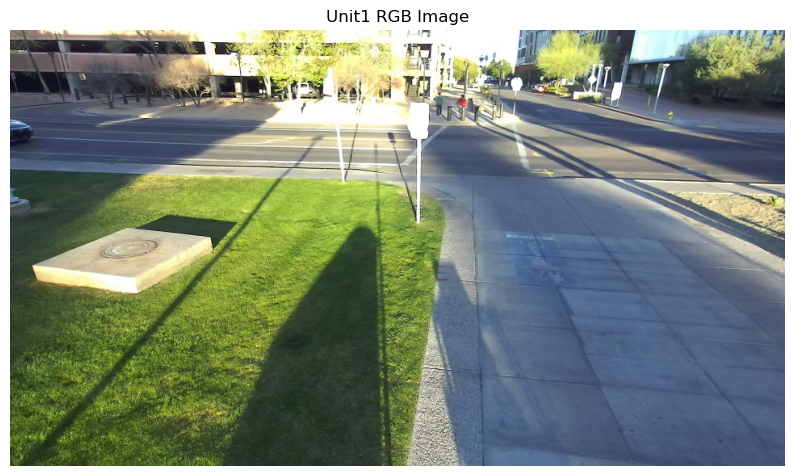

In [13]:
# 读取图像
image_path = sample['unit1_rgb']
try:
    img = imread(image_path)
    
    # 显示图像
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')  # 关闭坐标轴
    plt.title('Unit1 RGB Image')
    plt.show()
    
except FileNotFoundError:
    print(f"错误：未找到图像文件 '{image_path}'")
except Exception as e:
    print(f"错误：无法加载图像 - {str(e)}")

## 缩放图像

In [4]:
def resize_half_image(image_path: str, 
                      resize_method=Image.Resampling.LANCZOS) -> Image.Image:
    """
    将图像等比例缩小为原始大小的一半（保持宽高比）

    参数:
        image_path: 输入图像路径
        resize_method: 缩放算法

    返回:
        PIL.Image.Image: 处理后的RGB图像
    """
    # 1. 加载原图
    with open(image_path, 'rb') as f:
        img = Image.open(BytesIO(f.read())).convert('RGB')

    # 2. 获取原始尺寸，并计算目标尺寸
    original_w, original_h = img.size
    new_w, new_h = original_w // 2, original_h // 2

    # 3. 缩放图像
    img = img.resize((new_w, new_h), resize_method)

    # 4. 调试用可视化（可选）
    if True:  # 设为True可激活调试
        plt.figure(figsize=(10,5))
        plt.subplot(121).imshow(img)
        plt.title(f"Resized: {img.size}")
        plt.axis('off')
        plt.show()

    return img



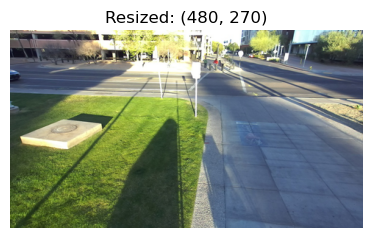

原始尺寸: 952x532 (示例)
处理后尺寸: (480, 270)


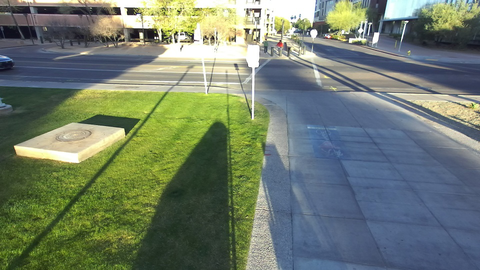

In [5]:
# 使用示例 ---------------------------------------------------

resized_img = resize_half_image(sample["unit1_rgb"])

print(f"原始尺寸: 952x532 (示例)")
print(f"处理后尺寸: {resized_img.size}")  # 输出: (476, 266)
display(resized_img)

## 批量缩放

In [16]:
import os
from PIL import Image
from tqdm import tqdm

def resize_half_image(image_path: str, resize_method=Image.Resampling.LANCZOS) -> Image.Image:
    img = Image.open(image_path).convert('RGB')
    original_w, original_h = img.size
    new_w, new_h = original_w // 2, original_h // 2
    img = img.resize((new_w, new_h), resize_method)
    return img

def process_all_images(
    input_base_dir,
    output_base_dir,
    scenarios=range(1, 10),
    file_ext='.png',  # 假设原始图像格式为PNG，可按需修改
):
    """
    批量处理图像：按原结构读取图像，将其缩小一半并保存至输出目录

    Args:
        input_base_dir (str): 输入数据根目录
        output_base_dir (str): 输出数据根目录
        scenarios (iterable): 要处理的情景编号（默认1-9）
        file_ext (str): 目标文件扩展名（如 .png, .jpg）
    """
    for scenario_num in scenarios:
        scenario_input = os.path.join(
            input_base_dir,
            f"scenario{scenario_num}",
            "unit1",
            "camera_data"
        )

        scenario_output = os.path.join(
            output_base_dir,
            f"scenario{scenario_num}",
            "unit1",
            "camera_resized"
        )

        if not os.path.exists(scenario_input):
            print(f"警告：输入目录不存在 {scenario_input}")
            continue

        os.makedirs(scenario_output, exist_ok=True)

        try:
            files = [f for f in os.listdir(scenario_input) if f.endswith(file_ext)]
        except Exception as e:
            print(f"无法读取目录 {scenario_input}: {str(e)}")
            continue

        if not files:
            print(f"提示：{scenario_input} 中没有 {file_ext} 文件")
            continue

        with tqdm(total=len(files), desc=f"场景 {scenario_num}") as pbar:
            for filename in files:
                input_path = os.path.join(scenario_input, filename)
                output_path = os.path.join(scenario_output, filename)
                try:
                    img = resize_half_image(input_path)
                    img.save(output_path)
                except Exception as e:
                    print(f"\n处理失败：{input_path} -> {str(e)}")
                finally:
                    pbar.update(1)

        print(f"完成：{scenario_output} 共处理 {len(files)} 张图像")


In [19]:
input_root = "/data2/wzj/Datasets/DeepSense"
output_root = "/data2/wzj/Datasets/DeepSense"

process_all_images(
    input_base_dir=input_root,
    output_base_dir=output_root,
    scenarios=range(1, 10),    # 处理 scenario1-9
    file_ext=".jpg"            # 按需修改为你的图像格式，如 .jpg
)


场景 1: 100%|██████████| 2411/2411 [00:43<00:00, 55.08it/s]


完成：/data2/wzj/Datasets/DeepSense/scenario1/unit1/camera_resized 共处理 2411 张图像


场景 2: 100%|██████████| 2974/2974 [00:55<00:00, 53.43it/s]


完成：/data2/wzj/Datasets/DeepSense/scenario2/unit1/camera_resized 共处理 2974 张图像


场景 3: 100%|██████████| 1487/1487 [00:27<00:00, 54.97it/s]


完成：/data2/wzj/Datasets/DeepSense/scenario3/unit1/camera_resized 共处理 1487 张图像


场景 4: 100%|██████████| 1867/1867 [00:34<00:00, 53.86it/s]


完成：/data2/wzj/Datasets/DeepSense/scenario4/unit1/camera_resized 共处理 1867 张图像


场景 5: 100%|██████████| 2300/2300 [00:44<00:00, 52.09it/s]


完成：/data2/wzj/Datasets/DeepSense/scenario5/unit1/camera_resized 共处理 2300 张图像


场景 6: 100%|██████████| 915/915 [00:16<00:00, 53.90it/s]


完成：/data2/wzj/Datasets/DeepSense/scenario6/unit1/camera_resized 共处理 915 张图像


场景 7: 100%|██████████| 854/854 [00:16<00:00, 52.18it/s]


完成：/data2/wzj/Datasets/DeepSense/scenario7/unit1/camera_resized 共处理 854 张图像


场景 8: 100%|██████████| 4043/4043 [01:15<00:00, 53.30it/s]


完成：/data2/wzj/Datasets/DeepSense/scenario8/unit1/camera_resized 共处理 4043 张图像


场景 9: 100%|██████████| 5964/5964 [01:52<00:00, 53.01it/s]

完成：/data2/wzj/Datasets/DeepSense/scenario9/unit1/camera_resized 共处理 5964 张图像


In [27]:
import os
import shutil
import pandas as pd
from pathlib import Path

def add_resized_image_column_only(csv_path, backup=True):
    """为 CSV 添加 unit1_camera_resized 列，值为缩放后图像路径（基于 unit1_rgb）"""
    try:
        csv_path = Path(csv_path)
        df = pd.read_csv(csv_path)
        original_shape = df.shape

        # 使用 unit1_rgb 列生成新的 resized 路径
        def get_resized_path(rgb_path):
            try:
                p = Path(rgb_path)
                return "./" + str(
                    p.parent.parent / "camera_resized" / p.name
                )
            except:
                return ""

        # 添加或更新新列
        df["unit1_camera_resized"] = df["unit1_rgb"].apply(get_resized_path)

        # 确保维度未变
        # if df.shape != original_shape:
        #     raise ValueError(f"数据维度从 {original_shape} 变为 {df.shape}")

        # 是否备份
        backup_path = csv_path.with_name(csv_path.stem + "_backup.csv")
        if backup and not backup_path.exists():
            shutil.copy(csv_path, backup_path)

        df.to_csv(csv_path, index=False)
        return True
    except Exception as e:
        print(f"处理失败：{csv_path} -> {str(e)}")
        return False


def batch_add_resized_column():
    """批量为 scenario1~9 的 csv 添加缩小图像路径列"""
    base_dir = "/data2/wzj/Datasets/DeepSense"

    for i in range(1, 10):
        csv_path = Path(base_dir) / f"scenario{i}" / f"scenario{i}.csv"
        if csv_path.exists():
            print(f"处理场景 {i}")
            add_resized_image_column_only(csv_path, backup=False)
        else:
            print(f"跳过不存在的文件：{csv_path}")


In [28]:
batch_add_resized_column()

处理场景 1
处理场景 2
处理场景 3
处理场景 4


处理场景 5
处理场景 6
处理场景 7
处理场景 8
处理场景 9


## 加载数据集查看效果

In [29]:
from datasets import load_dataset, concatenate_datasets

# 手动指定场景 1-8 的路径
scenario_paths = [f'/data2/wzj/Datasets/DeepSense/scenario{i}/scenario{i}.csv' for i in range(1, 9)]

# 分别加载每个场景的数据集
datasets_list = []
for path in scenario_paths:
    try:
        subset = load_dataset('csv', data_files=path, split='train')
        print(f"成功加载 {path}: {len(subset)} 个样本")
        datasets_list.append(subset)
    except Exception as e:
        print(f"加载失败: {path} - 错误: {e}")

# 合并所有有效数据集
if datasets_list:
    dataset = concatenate_datasets(datasets_list)
    print(f"合并后的总样本数: {len(dataset)}")
else:
    print("未找到任何有效 CSV 文件！")

print(dataset)  # 查看数据集的基本信息
print(dataset.num_rows)  # 查看行数
print(dataset.column_names)  # 查看列名


Generating train split: 0 examples [00:00, ? examples/s]

成功加载 /data2/wzj/Datasets/DeepSense/scenario1/scenario1.csv: 2411 个样本


Generating train split: 0 examples [00:00, ? examples/s]

成功加载 /data2/wzj/Datasets/DeepSense/scenario2/scenario2.csv: 2974 个样本


Generating train split: 0 examples [00:00, ? examples/s]

成功加载 /data2/wzj/Datasets/DeepSense/scenario3/scenario3.csv: 1487 个样本


Generating train split: 0 examples [00:00, ? examples/s]

成功加载 /data2/wzj/Datasets/DeepSense/scenario4/scenario4.csv: 1867 个样本


Generating train split: 0 examples [00:00, ? examples/s]

成功加载 /data2/wzj/Datasets/DeepSense/scenario5/scenario5.csv: 2300 个样本


Generating train split: 0 examples [00:00, ? examples/s]

成功加载 /data2/wzj/Datasets/DeepSense/scenario6/scenario6.csv: 915 个样本


Generating train split: 0 examples [00:00, ? examples/s]

成功加载 /data2/wzj/Datasets/DeepSense/scenario7/scenario7.csv: 854 个样本


Generating train split: 0 examples [00:00, ? examples/s]

成功加载 /data2/wzj/Datasets/DeepSense/scenario8/scenario8.csv: 4043 个样本
合并后的总样本数: 16851
Dataset({
    features: ['index', 'unit1_rgb', 'unit1_pwr_60ghz', 'unit1_loc', 'unit2_loc', 'Unnamed: 5', 'unit1_beam_index', 'seq_index', 'time_stamp[UTC]', 'unit2_direction', 'unit2_num_sat', 'unit2_sat_used', 'unit2_fix_type', 'unit2_DGPS', 'unit2_PDOP', 'unit2_HDOP', 'unit1_mmwave_heatmap', 'unit1_camera_resized', 'unit1_lidar', 'unit1_lidar_SCR', 'unit2_loc_cal', 'Unnamed: 8'],
    num_rows: 16851
})
16851
['index', 'unit1_rgb', 'unit1_pwr_60ghz', 'unit1_loc', 'unit2_loc', 'Unnamed: 5', 'unit1_beam_index', 'seq_index', 'time_stamp[UTC]', 'unit2_direction', 'unit2_num_sat', 'unit2_sat_used', 'unit2_fix_type', 'unit2_DGPS', 'unit2_PDOP', 'unit2_HDOP', 'unit1_mmwave_heatmap', 'unit1_camera_resized', 'unit1_lidar', 'unit1_lidar_SCR', 'unit2_loc_cal', 'Unnamed: 8']


In [30]:
print(dataset['unit1_camera_resized'][:1])

['./unit1/camera_resized/image_BS1_456_00_42_15.jpg']


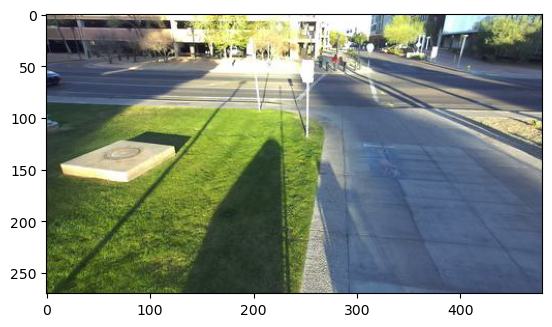

In [34]:
img_resize = imread('/data2/wzj/Datasets/DeepSense/scenario1/unit1/camera_resized/image_BS1_456_00_42_15.jpg')
plt.imshow(img_resize)

### 成功将图像缩小并且添加路径到scenarioX.csv文件中